<a href="https://colab.research.google.com/github/jpantojac/dMet/blob/main/modelamiento/dMet_modelamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bienvenido al Diplomado de Meteorologia**


---




En este espacio se realizaran las entregas de los ejercicios propuestos


In [8]:
#!apt-get install libproj-dev proj-data proj-bin
#!apt-get install libgeos-dev
#!pip install cython
#!pip install cartopy
#!pip install pydrive
#!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

Selecting previously unselected package python-pkg-resources.
(Reading database ... 123957 files and directories currently installed.)
Preparing to unpack .../00-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../01-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../02-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../03-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../04-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-numpy.
Preparing to unpack .../05-python

In [ ]:
!pip install -U -q wrf-python

In [1]:
import os

print("Bienvenido")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1dh0EcrDUALX4lhTLVFmvndxhQIAyqaJe'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('wrfout_d02_2022-10-13_00_00_00.nc')  
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
print("Hecho")


Bienvenido
Hecho


In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

MessageError: ignored

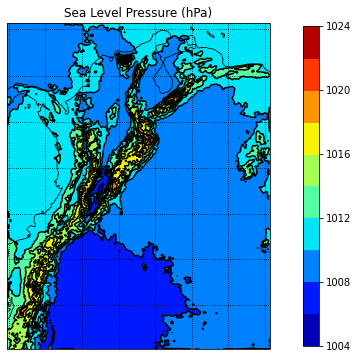

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
 

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,cartopy_ylim, latlon_coords)

# Open the NetCDF file
ncfile = Dataset("/content/wrfout_d02_2022-10-13_00_00_00.nc")
# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the
# mountains
smooth_slp = smooth2d(slp, 3, cenweight=4)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,6))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
#states = NaturalEarthFeature(category="cultural", scale="50m",
#                             facecolor="none",
#                             name="admin_1_states_provinces_shp")
#ax.add_feature(states, linewidth=.5, edgecolor="black")
#ax.coastlines('50m', linewidth=0.8)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, linewidth=.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)



# Make the contour outlines and filled contours for the smoothed sea level
# pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10,
             transform=crs.PlateCarree(),
             cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.98)

# Set the map bounds
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.show()


